In this experiment, we iterated resamplers for each boosting algorithm in each dataset.

The results of the experiments are saved in the csv tables.

The results of applying the most successful algorithms for each algorithm in each dataset are also saved in tables.

Two things to remember:

1. Splipping in the LogitBoost, MEBoost, AdaBoost, RUSBoost, GradientBoostingClassifier algorithms is implemented internally. See the implementation of models in Boosting_models.py. Moreover, in some of them it can be used globally (that is, before the start of training) and locally (in each iteration of boosting training). The combination of the local sampler RUS and the AdaBoost algorithm essentially gives the RUSBoost algorithm.

2. In the case of algorithms taken from ready-made libraries, resampling is used immediately before training on a sample of trains. That is, after splitting into M-fold. See the implementation in metrics_append.py.

In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

from Boosting_models import MulticlassClassificationOvR, LogitBoost, MEBoost, AdaBoost, RUSBoost, GradientBoostingClassifier

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_14529/4210027258.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# imprort resamplings
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, DecisionTreeRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN,  BorderlineSMOTE
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN, CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.under_sampling import InstanceHardnessThreshold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
import random

def undersampling(X, Y):
    '''Check the major class'''
    diff = Y.sum() > Y.shape[0] - Y.sum()
    delete_list = []
    keep_list =[]
    if  diff:
        for i in range(len(Y)):
            if Y[i] == 1:
                delete_data = [i, X[i], 1]
                delete_list.append(delete_data)
            else:
                keep_data = [i, X[i], 0]
                keep_list.append(keep_data)
    else:
        for i in range(len(Y)):
            if Y[i] == 0:
                delete_data = [i, X[i], 0]
                delete_list.append(delete_data)
            else:
                keep_data = [i, X[i], 1]
                keep_list.append(keep_data)

    while len(delete_list) > 0.5*(len(delete_list)+len(keep_list)):
        k = random.choice(range(len(delete_list)))
        delete_list.pop(k)

    all_list = delete_list + keep_list
    return sorted(all_list, key=lambda x:x[2])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from all_metrics_append import metrics_append
from dataset_loader import load_dataset, preprocessing

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# dictionary with resamplers
samplers = {"RUS": undersampling,
            "RandomOverSampler": RandomOverSampler(random_state=42),
            "SMOTE": SMOTE(random_state=42),
            "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
            "ClusterCentroids": ClusterCentroids(random_state=0),
            "NearMiss": NearMiss(version=1),
            "EditedNearestNeighbours": EditedNearestNeighbours(),
            "RepeatedEditedNearestNeighbours": RepeatedEditedNearestNeighbours(),
            "CondensedNearestNeighbour": CondensedNearestNeighbour(random_state=0),
            "OneSidedSelection": OneSidedSelection(random_state=0),
            "NeighbourhoodCleaningRule": NeighbourhoodCleaningRule(n_neighbors=11),
            "Without sampler": None
}

bin_clf_c = {"MEBoost": MEBoost,  # for this algorithms DecissionTreeClassifier should be used
             "AdaBoost": AdaBoost}

bin_clf_r = {"LogitBoost": LogitBoost, # for this algorithms DecisstionTreeRegressor should be used
             "GradientBoostingClassifier": GradientBoostingClassifier}

library_clf = {'XGBClassifier': XGBClassifier, # alogorithm from free libraries
               'CatBoostClassifier': CatBoostClassifier}

# init baseestimators 
base_estimator_clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2, random_state=42) 
base_estimator_reg = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=2, random_state=42)

# datasets names sorted by MeanIR
dataset_names = ["Pen-Based_Recognition_of_Handwritten_Digits", "Hayes_Roth",
                 "Wine", "Contraceptive_Method_Choice", "Balance_Scale",
                 "Differentiated_Thyroid_Cancer_Recurrence", "Vertebral_Column",
                 "Dermatology", "Thyroid_Disease",
                 "Glass_Identification",
                 "Heart_Disease",
                 "Car_Evaluation",
                 "Yeast",
                 "Covertype", 
                 "Statlog_Shuttle"
                ]



for dataset_name in dataset_names: # iterate over datasets
    f1_scores = {"Resampling": ["RUS",  # dictionary to save F1_scores
                                "RandomOverSampler",
                                "SMOTE",
                                "BorderlineSMOTE", 
                                "ClusterCentroids",
                                "NearMiss",
                                "EditedNearestNeighbours",
                                "RepeatedEditedNearestNeighbours",
                                "CondensedNearestNeighbour",
                                "OneSidedSelection",
                                "NeighbourhoodCleaningRule",
                                "Without sampler"
                               ],
             "MEBoost": [],
             "AdaBoost": [],
             "LogitBoost": [],
             "GradientBoostingClassifier": [],
             "XGBClassifier": [],
             "CatBoostClassifier": []}

    # load data without spliting
    X, y = load_dataset(dataset_name)
    
    for sampler_name in samplers: # iterate over samplers

      for clf_name in bin_clf_c: # iterate algorithms with DTClassifier as base_estimator
        # !! (Resampler is implemented to the boosting algorithm)  
        bin_clf = bin_clf_c[clf_name](n_estimators=50, base_estimator = base_estimator_clf, sampler = samplers[sampler_name], sampler_type = "Global")
        # create Multiclass classification with bin clf
        mclf_boost_model = MulticlassClassificationOvR(bin_clf)
        # find metrics via M-fold  
        metrics = metrics_append(X, y, mclf_boost_model, preprocessing, return_str=False)
        f1_scores[clf_name].append(metrics["F1"]) # Save F1 score to find best resampler
    
      for clf_name in bin_clf_r: # iterate algorithms with DTRegressor as base_estimator
        bin_clf = bin_clf_r[clf_name](n_estimators=50, base_estimator = base_estimator_reg, sampler = samplers[sampler_name])
        # create Multiclass classification with bim clf
        mclf_boost_model = MulticlassClassificationOvR(bin_clf)
        # find metrics via M-fold
        metrics = metrics_append(X, y, mclf_boost_model, preprocessing, return_str=False)
        f1_scores[clf_name].append(metrics["F1"]) # Save F1 score to find best resampler
    
      for clf_name in library_clf: # iterate algorithms from free library
        bin_clf = library_clf[clf_name](n_estimators=50, verbose = 0)
        # create Multiclass classification as in previous case    
        mclf_boost_model = MulticlassClassificationOvR(bin_clf)
        # !! (In this case Resampling is implemented to the M-fold process)  
        metrics = metrics_append(X, y, mclf_boost_model, preprocessing, return_str=False, sampling = samplers[sampler_name])
        f1_scores[clf_name].append(metrics["F1"]) # save F1 score into dictionary

    # save the results for dataset to csv file
    f1_scores_pd = pd.DataFrame(f1_scores)
    file_name = f'Experiment_3/{dataset_name}.csv'
    f1_scores_pd.to_csv(file_name, index = False)


In [2]:
# Example for one on the dataset
results = pd.read_csv(f'Experiment_3/{"Wine"}.csv')
results.head(20)

,Resampling,MEBoost,AdaBoost,LogitBoost,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier
0,RUS,0.927726,0.977249,0.933280,0.966345,0.600046,0.607308
1,RandomOverSampler,0.889161,0.988912,0.933394,0.960899,0.972460,0.972150
2,SMOTE,0.894756,0.977433,0.939081,0.977786,0.966582,0.966064
3,BorderlineSMOTE,0.912189,0.988902,0.933394,0.983331,0.966582,0.972150
4,ClusterCentroids,0.927614,0.966167,0.938894,0.971750,0.955397,0.954586
5,NearMiss,0.949918,0.960869,0.939038,0.960936,0.926658,0.920181
6,EditedNearestNeighbours,0.905751,0.971942,0.933280,0.955138,0.925977,0.943010
7,RepeatedEditedNearestNeighbours,0.913963,0.960781,0.933280,0.949500,0.926588,0.931213
8,AllKNN,0.878180,0.971942,0.933280,0.949500,0.937646,0.931601
9,CondensedNearestNeighbour,0.949095,0.891089,0.840730,0.817461,0.926370,0.926450


In [19]:
# in this section for each dataset and each boosting algorithm we find the 
# best choice resampler and save as csv file with comparison with baseline

algorithms_names = ["MEBoost", "AdaBoost", "LogitBoost", "GradientBoostingClassifier", "XGBClassifier", "CatBoostClassifier"]

covvertype = {"MEBoost": 0.256,  # baseline scores for covertype dataset
              "AdaBoost": 0.638,
              "LogitBoost": 0.525,
              "GradientBoostingClassifier": 0.663,
              "XGBClassifier": 0.87,
              "CatBoostClassifier": 0.804}

for dataset_name in dataset_names: # iterate datasets

  best_parameters = {"Algorithm": [], "Best resampler": [], "Best score": [], "Score baseline": []}

  try:
    results = pd.read_csv(f'Experiment_3/{dataset_name}.csv') # read file with scores for each resampler
  except:
    print(f'Except {dataset_name}')
    continue
  
  for alg_name in algorithms_names: # iterate algorithms
    # upload baseline (in files with scores it is written as "Without sampler"
    try:
        select_indices = list(np.where(results["Resampling"] == 'Without sampler')[0])
        cut_value = results[alg_name].iloc[select_indices].item()
    except:
        cut_value = covvertype[alg_name]

    # find best resampler and its score  
    best_index = results[[alg_name]].idxmax()
    best_resampler = results["Resampling"].iloc[best_index].item()
    best_score = results[alg_name].iloc[best_index].item()

    # save best params to dictionary  
    best_parameters["Score baseline"].append(round(cut_value, 3))
    best_parameters["Algorithm"].append(alg_name)
    best_parameters["Best resampler"].append(best_resampler)
    best_parameters["Best score"].append(round(best_score, 3))

  # Save result of comparison for dataset  
  f1_scores_pd = pd.DataFrame(best_parameters)
  file_name = f'Experiment_3/Best_resample_{dataset_name}.csv'
  f1_scores_pd.to_csv(file_name, index = False)

In [3]:
# Example for one on the dataset
best_results = pd.read_csv(f'Experiment_3/Best_resample_{"Wine"}.csv') 
best_results.head(20)

,Algorithm,Best resampler,Best score,Score baseline
0,MEBoost,NearMiss,0.950,0.880
1,AdaBoost,RandomOverSampler,0.989,0.983
2,LogitBoost,SMOTE,0.939,0.933
3,GradientBoostingClassifier,BorderlineSMOTE,0.983,0.966
4,XGBClassifier,RandomOverSampler,0.972,0.967
5,CatBoostClassifier,RandomOverSampler,0.972,0.972


In [ ]:
# In this section we compare performave of the LogitBoost algorithm after the using the Best resampler
# with the baseline. In both cases the result is recomputed in order to get std.

dataset_res = {"Dataset": [], "Sampler_for_adaboost": [], "F1_mean": [], "F1_std": [], "init_F1_mean": [], "init_F1_std": []}


for dataset_name in dataset_names:
  try:
    results = pd.read_csv(f'Experiment_3/Best_resample_{dataset_name}.csv')
    X, y = load_dataset(dataset_name)
  except:
    print(f'Except {dataset_name}')
    continue


  # select_indices = list(np.where(results["Algorithm"] == "AdaBoost")[0])
  select_indices = list(np.where(results["Algorithm"] == "LogitBoost")[0])
    
  sampler_name = results["Best resampler"].iloc[select_indices].item() # upload best resampler name

  # base_estimator = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2, random_state=42)
  # bin_clf = AdaBoost(n_estimators=50, base_estimator = base_estimator, sampler = samplers[sampler_name], sampler_type = "Global")

  # compute score with the best resampler
  base_estimator_reg = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=2, random_state=42)
  bin_clf = LogitBoost(n_estimators=50, base_estimator = base_estimator_reg, sampler = samplers[sampler_name])

  # create multiclass classificator  
  mclf_boost_model = MulticlassClassificationOvR(bin_clf)
  # compute metrics via M-fold
  metrics = metrics_append(X, y, mclf_boost_model, preprocessing, return_str=False)

  # save result with resampler
  dataset_res["Dataset"].append(dataset_name)
  dataset_res["Sampler_for_adaboost"].append(sampler_name)
  dataset_res["F1_mean"].append(metrics["F1"][0])
  dataset_res["F1_std"].append(metrics["F1"][1])

  # compute score without resampler
  base_estimator_reg = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=2, random_state=42)
  bin_clf = LogitBoost(n_estimators=50, base_estimator = base_estimator_reg, sampler = None)
  
  mclf_boost_model = MulticlassClassificationOvR(bin_clf
  metrics = metrics_append(X, y, mclf_boost_model, preprocessing, return_str=False)

  dataset_res["init_F1_mean"].append(metrics["F1"][0])
  dataset_res["init_F1_std"].append(metrics["F1"][1])

# save results as csv file
f1_scores_pd = pd.DataFrame(dataset_res)
file_name = f'Experiment_3/Resampling_LogitBoost(datasets).csv'
f1_scores_pd.to_csv(file_name, index = False) 


In [4]:
f1_scores_pd = pd.read_csv(f'Experiment_3/Resampling_LogitBoost(datasets).csv') 
f1_scores_pd.head(20)

,Dataset,Sampler_for_adaboost,F1_mean,F1_std,init_F1_mean,init_F1_std
0,Pen-Based_Recognition_of_Handwritten_Digits,ClusterCentroids,0.843193,0.016807,0.543452,0.034408
1,Hayes_Roth,CondensedNearestNeighbour,0.779049,0.045127,0.477544,0.105521
2,Wine,SMOTE,0.939081,0.038517,0.933394,0.046560
3,Contraceptive_Method_Choice,RepeatedEditedNearestNeighbours,0.545548,0.007869,0.255562,0.000977
4,Balance_Scale,EditedNearestNeighbours,0.717624,0.011575,0.209014,0.005210
5,Differentiated_Thyroid_Cancer_Recurrence,BorderlineSMOTE,0.965679,0.013464,0.943573,0.011640
6,Vertebral_Column,BorderlineSMOTE,0.856436,0.040751,0.816420,0.026647
7,Dermatology,RUS,0.922520,0.042894,0.880627,0.031501
8,Thyroid_Disease,SMOTE,0.971021,0.020850,0.941499,0.021695
9,Glass_Identification,SMOTE,0.636718,0.129585,0.420084,0.051773


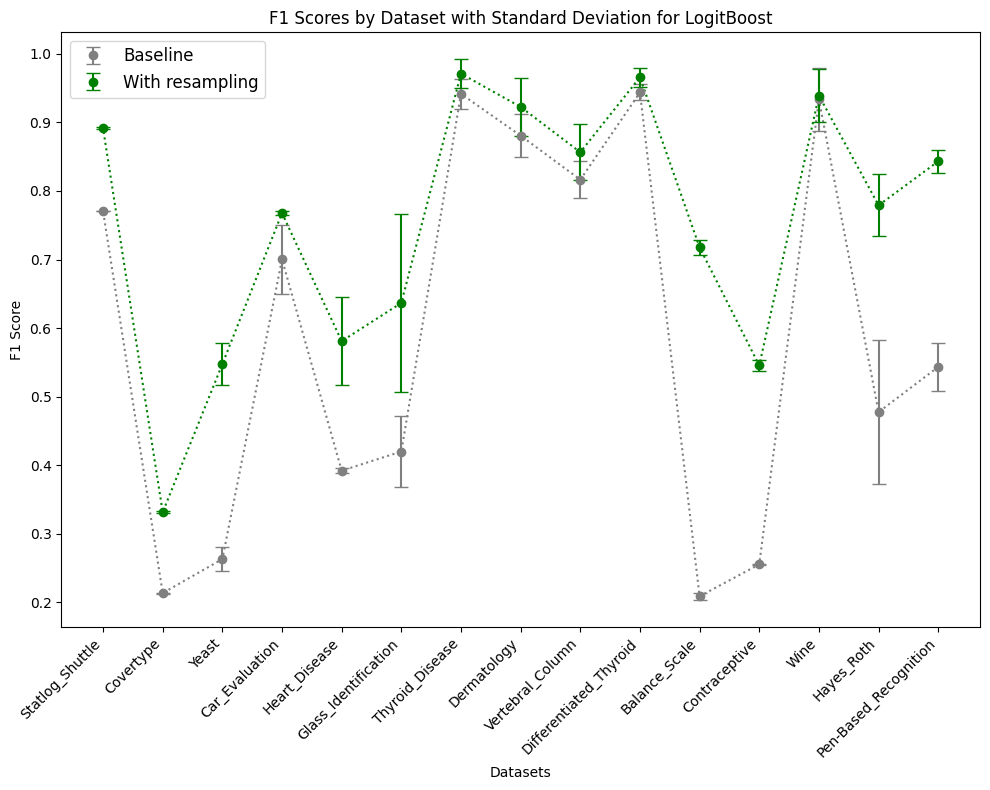

In [41]:
from matplotlib.transforms import Affine2D
# fig, ax = plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(figsize=(10, 8))

df_names = pd.read_csv('logidboost_baseline.csv')["Dataset"] # to load short names of datasets

df_base = f1_scores_pd[["Dataset", "init_F1_mean", "init_F1_std"]]
df_base["Dataset"] = df_names
df = f1_scores_pd[["Dataset", "F1_mean", "F1_std"]]

plt.plot(range(len(df_base)), df_base["init_F1_mean"], color='grey', linestyle=':')
plt.errorbar(x=range(len(df_base)), y=df_base["init_F1_mean"], 
             yerr=df_base["init_F1_std"], fmt='o', 
             color='grey', capsize=5,
             # transform=trans1,
             label='Baseline')

plt.plot(range(len(df_base)), df["F1_mean"], color='green', linestyle=':')
plt.errorbar(x=range(len(df_base)), y=df["F1_mean"], yerr=df["F1_std"],
             fmt='o', color='green',
             capsize=5,
             # transform=trans2,
             label='With resampling')

plt.xticks(range(len(df_base)), df_base['Dataset'], rotation=45, ha='right')

plt.title('F1 Scores by Dataset with Standard Deviation for LogitBoost')
plt.ylabel('F1 Score')
plt.xlabel('Datasets')
plt.legend(fontsize='12')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('result.png')
plt.show()